# ML_IndustrialMachineStatus: Predicting Machine Maintenance

**Project Goal:**  
This project aims to predict machine maintenance needs based on numeric industrial sensor data.  
The dataset contains **654 records** with **5 numeric columns** suitable for binary classification models.  
The target (`target`) indicates whether a machine requires maintenance (`1`) or operates normally (`0`).  
The data includes variations, noise, and missing values to reflect realistic industrial conditions.

---

**Column Descriptions:**

- **temp_sensor (float):**  
  Machine temperature in °C. Includes a few unusual readings.

- **vibration (float):**  
  Vibration intensity (m/s²). Some values represent abnormal sensor behavior.

- **power_output (float):**  
  Power output in kilowatts (kW). Includes occasional extreme measurements.

- **pressure (float):**  
  Internal system pressure (bar). Contains a small amount of inconsistent data.

- **efficiency (float):**  
  Energy efficiency percentage. Slightly correlated with pressure and power output.

- **target (int: 0/1):**  
  Indicates machine status: `0` = normal operation, `1` = maintenance required.

---

**Note:**  
The dataset contains a range of sensor values with minor irregularities,  
making it suitable for practicing **data preprocessing**, **anomaly detection**,  
and **binary classification modeling**.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

In [2]:
# Reading data from a CSV file and displaying all information
data = pd.read_csv('factory_machine_health.csv')
pd.set_option('display.width',1000)
print(data.head(5).round(2),'\n')     # Display the first 5 rows of the dataset
print(data.shape,'\n')                # Display the number of rows and columns in the dataset
print(data.describe().round(2),'\n')  # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)
print(data.groupby('target').size())  # Grouping data by target to check distribution

   temp_sensor  vibration  power_output  pressure  efficiency  target
0        79.97      10.15        243.44     11.56       81.33       1
1        73.62       5.12        218.99       NaN       85.41       1
2        81.48       5.03        199.00     11.67       87.29       0
3        90.23       4.95        232.71     10.27       92.28       1
4        72.66        NaN        255.61      9.41       88.52       0 

(654, 6) 

       temp_sensor  vibration  power_output  pressure  efficiency  target
count       646.00     646.00        646.00    646.00      646.00  654.00
mean         73.43       5.06        199.49      9.96       84.41    0.21
std          21.21       2.45         65.00      4.21       21.43    0.41
min        -173.59     -11.53       -444.50    -29.20     -171.09    0.00
25%          67.81       3.76        175.47      8.02       81.48    0.00
50%          74.87       5.16        200.34     10.00       85.15    0.00
75%          81.29       6.42        229.45     1

# Handling Missing Values and Outliers

Some sensor readings in the dataset contain missing values and a few extreme outliers.  
These issues may come from temporary sensor failures, calibration errors, or irregular machine behavior.  
Because the percentage of missing data is small and the dataset includes potential outliers,  
we will handle missing values using the **median** instead of the mean.

**Why use the median?**  
The median is more robust against extreme readings that can appear due to faulty sensors or momentary spikes.  
Using the median preserves the overall data distribution and prevents the model from being biased by outliers.  
This approach helps ensure more stable and reliable predictions for machine maintenance.

In [3]:
num_col = ['temp_sensor','vibration','power_output','pressure','efficiency']
for col in num_col:
    data[col] = data[col].fillna(data[col].median())

# Updated Data Summary

We re-run `data.describe()` after recent cleaning steps to obtain the current summary statistics.  
During preprocessing we handled missing entries and addressed a number of anomalous readings, so the table below reflects the post-cleaning state.

**What changed?**  
- Missing values were imputed (where applicable).  
- Suspected outliers were reviewed and either corrected, capped, or removed.  
- As a result, summary metrics such as **count**, **mean**, **std**, **min**, and **max** may differ from earlier outputs.

**Note:**  
This updated summary should be used as the reference for subsequent feature scaling, modeling, and interpretation steps.

In [4]:
print(data.describe().round(2),'\n')  # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)

       temp_sensor  vibration  power_output  pressure  efficiency  target
count       654.00     654.00        654.00    654.00      654.00  654.00
mean         73.45       5.06        199.50      9.96       84.42    0.21
std          21.08       2.43         64.61      4.18       21.30    0.41
min        -173.59     -11.53       -444.50    -29.20     -171.09    0.00
25%          67.85       3.78        175.55      8.05       81.55    0.00
50%          74.87       5.16        200.34     10.00       85.15    0.00
75%          81.25       6.40        228.86     11.96       88.38    0.00
max         194.27      14.80        638.77     41.14      267.70    1.00 



# Data Visualization

In this section, we explore the distribution and relationships of key features using  
**Histogram**, **Density Plot**, **Box Plot**, and a **Heatmap** for correlation analysis.

These visualizations help identify variable distributions, potential outliers,  
and dependencies between features before building predictive models.

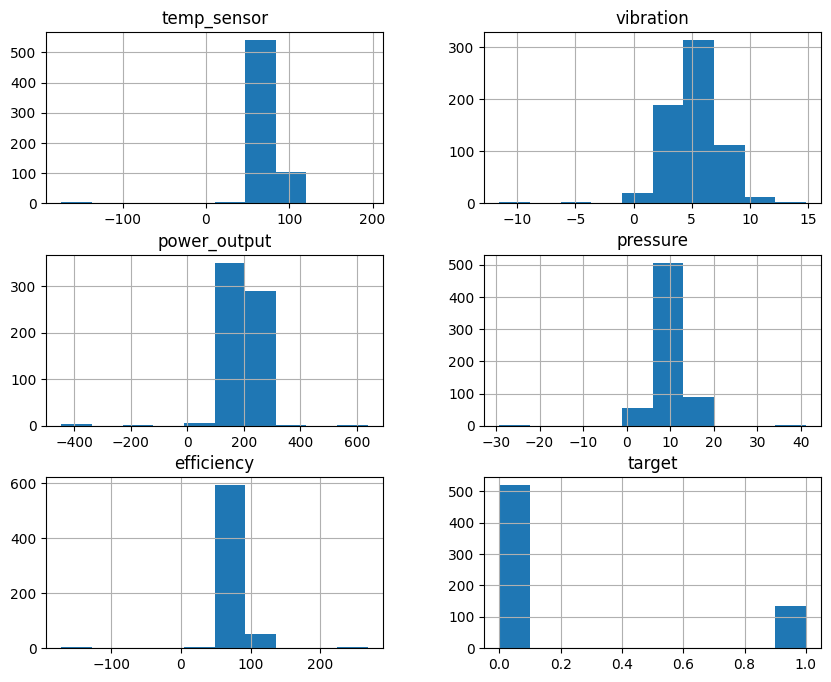

In [5]:
data.hist(figsize=(10,8))
plt.show()

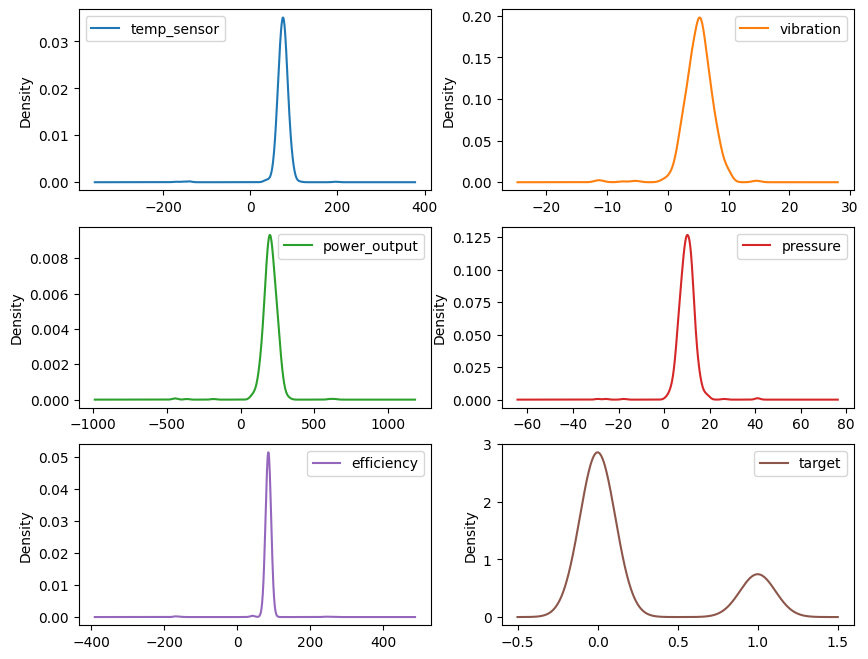

In [6]:
data.plot(kind='density',subplots=True,layout=(3,2),sharex=False,figsize=(10,8))
plt.show()

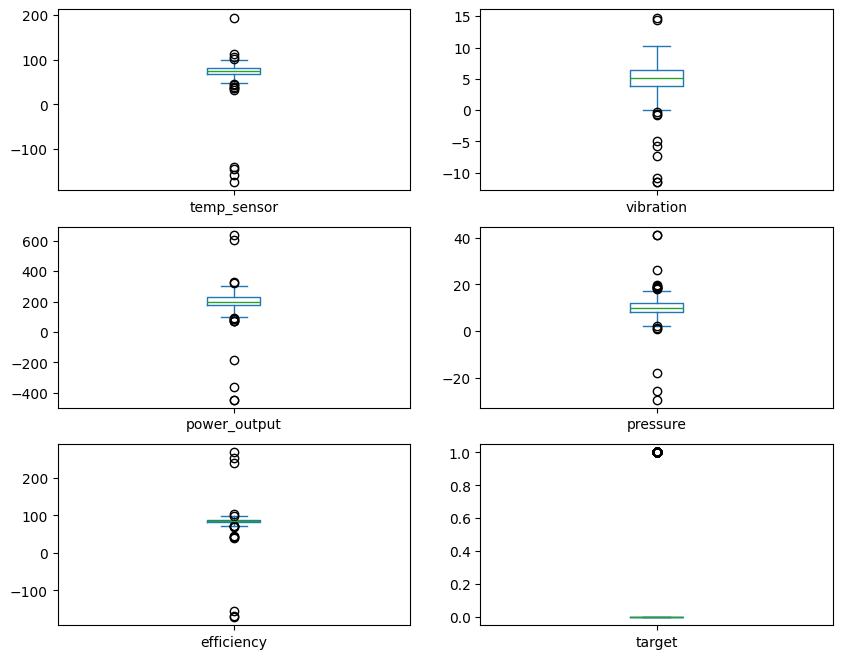

In [7]:
data.plot(kind='box',subplots=True,layout=(3,2),sharex=False,figsize=(10,8))
plt.show()

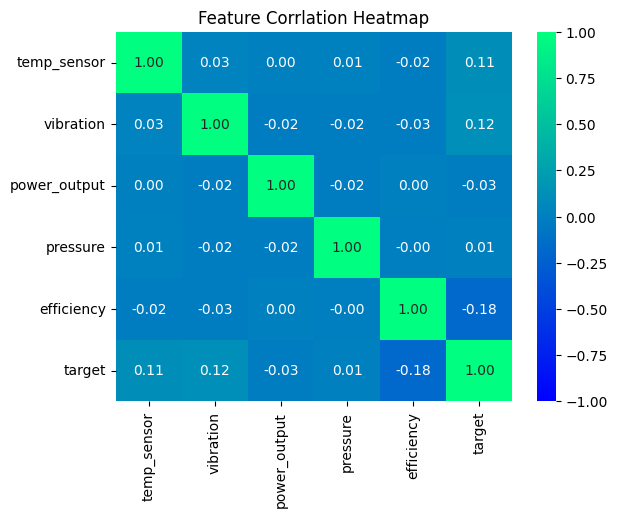

In [8]:
sns.heatmap(data.corr(),vmin=-1,vmax=1,cmap='winter',annot=True,fmt='.2f')
plt.title('Feature Corrlation Heatmap')
plt.show()

# Train–Test Split

We divide the dataset into **training** and **testing** sets to evaluate model performance on unseen data.  
This ensures the model learns general patterns from the training set and is validated objectively on the test set.  
A typical split ratio of **78/22** is used to balance learning and evaluation.

In [9]:
X = data.drop(columns=['target'])
Y = data['target']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.22,random_state=7)

# Spot-Check and Model Unpacking

In this step, we perform an initial **spot-check** by training several baseline models to get a sense of their behavior.  
Each model is defined, trained, and evaluated separately to understand its characteristics and potential.  

The models included in this stage are:
- **Logistic Regression**
- **Linear Discriminant Analysis (LDA)**
- **K-Nearest Neighbors (KNN)**
- **Gaussian Naive Bayes**
- **Decision Tree (CART)**
- **Support Vector Classifier (SVC)**

This step helps unpack how different algorithms respond to the dataset before moving on to fine-tuning and ensemble methods.

Name : LR , Accuracy : 79.41 % , STD : 5.90
Name : LDA , Accuracy : 79.02 % , STD : 6.08
Name : KNN , Accuracy : 82.55 % , STD : 5.44
Name : NB , Accuracy : 79.02 % , STD : 5.26
Name : CART , Accuracy : 79.61 % , STD : 6.21
Name : SVM , Accuracy : 79.41 % , STD : 6.34


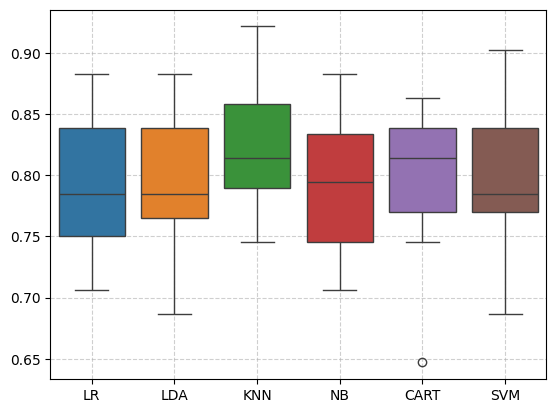

In [10]:
# Spot Check
models = []
models.append(('LR',LogisticRegression(max_iter=1000)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVM',SVC()))
# Model Unpacking
result = []
names = []
for name , model in models:
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(model,x_train,y_train,cv=kfold,scoring='accuracy')
    result.append(cv_result)
    names.append(name)
    print(f'Name : {name} , Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
result_df = pd.DataFrame(result,index=names).T
sns.boxplot(data=result_df)
plt.grid(True,linestyle='--',alpha=0.6)
plt.show()

# Data Standardization with Pipeline

We standardize the dataset using a **Pipeline** to improve model performance.  
Scaling ensures that all features contribute equally to learning,  
helping algorithms like **KNN**, **SVM**, and **Logistic Regression** achieve higher accuracy.

Name : LR , Accuracy : 79.41 % , STD : 5.90
Name : LDA , Accuracy : 79.02 % , STD : 6.08
Name : KNN , Accuracy : 80.20 % , STD : 6.53
Name : NB , Accuracy : 79.02 % , STD : 5.26
Name : CART , Accuracy : 79.61 % , STD : 6.09
Name : SVM , Accuracy : 79.80 % , STD : 6.01


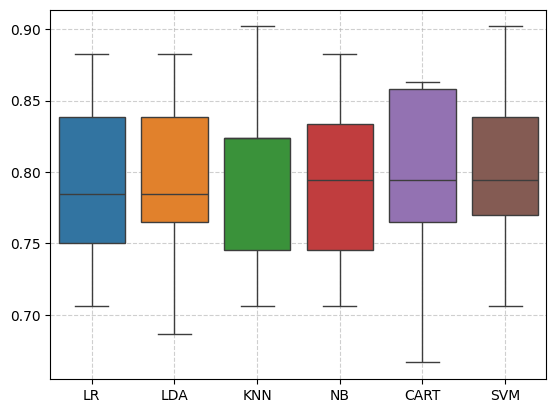

In [11]:
scaled_result = []
for name , model in models:
    pipeline = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(pipeline,x_train,y_train,cv=kfold,scoring='accuracy')
    scaled_result.append(cv_result)
    print(f'Name : {name} , Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
scaled_result_df = pd.DataFrame(scaled_result,index=names).T
sns.boxplot(data=scaled_result_df)
plt.grid(True,linestyle='--',alpha=0.6)
plt.show()

# Model Selection for Hyperparameter Tuning

We selected **CART**, **SVM**, and **KNN** for hyperparameter tuning.  
These models showed strong baseline results and complementary learning behaviors:  
- **CART** can handle noisy and non-linear relationships well.  
- **SVM** performs effectively on complex decision boundaries.  
- **KNN** benefits from scaling and can capture local data patterns.  

By tuning their parameters, we aim to further improve model performance and stability.

In [12]:
# Setting Kfold
kfold = KFold(n_splits=10,shuffle=True,random_state=7)
# Cart
cart_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',DecisionTreeClassifier())
])
cart_param_grid = {
    'Classifier__max_depth' : [3,5,7,9,None],
    'Classifier__min_samples_split' : [2,5,10],
    'Classifier__min_samples_leaf' : [1,2,4],
    'Classifier__criterion' : ['gini','entropy']
}
cart_grid = GridSearchCV(
    estimator=cart_pipe,
    param_grid=cart_param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=kfold
)
cart_grid.fit(x_train,y_train)
print(f'DecisionTreeClassifier - Best CV accuracy : {cart_grid.best_score_*100:.2f}')
print(f'DecisionTreeClassifier - Best params : {cart_grid.best_params_}')

DecisionTreeClassifier - Best CV accuracy : 89.02
DecisionTreeClassifier - Best params : {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__min_samples_leaf': 4, 'Classifier__min_samples_split': 5}


In [13]:
# SVM
svm_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',SVC())
])
svm_param_grid = {
    'Classifier__C' : [0.1,1,10,100],
    'Classifier__kernel' : ['linear','rbf','poly'],
    'Classifier__gamma' : ['scale','auto']
}
svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=kfold
)
svm_grid.fit(x_train,y_train)
print(f'SVM - Best CV accuracy : {svm_grid.best_score_*100:.2f}')
print(f'SVM - Best params : {svm_grid.best_params_}')

SVM - Best CV accuracy : 81.96
SVM - Best params : {'Classifier__C': 10, 'Classifier__gamma': 'scale', 'Classifier__kernel': 'rbf'}


In [14]:
# KNN
knn_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',KNeighborsClassifier())
])
knn_param_grid = {
    'Classifier__n_neighbors' : [3,5,7,9,11],
    'Classifier__weights' : ['uniform','distance'],
    'Classifier__metric' : ['manhattan','euclidean']
}
knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=kfold
)
knn_grid.fit(x_train,y_train)
print(f'KNeighborsClassifier - Best CV accuracy : {knn_grid.best_score_*100:.2f}')
print(f'KNeighborsClassifier - Best params : {knn_grid.best_params_}')

KNeighborsClassifier - Best CV accuracy : 80.98
KNeighborsClassifier - Best params : {'Classifier__metric': 'manhattan', 'Classifier__n_neighbors': 9, 'Classifier__weights': 'distance'}


# Final Model Selection and Next Step: Prediction

After hyperparameter tuning, the **Decision Tree (CART)** model achieved the highest cross-validation accuracy of **89%**,  
outperforming other candidates such as **SVM** and **KNN**.

The tuned parameters helped the model generalize well by preventing overfitting and focusing on meaningful data patterns.  
Given its strong accuracy, interpretability, and computational efficiency, we decided to **select CART as the final model**.

Since the model already shows stable and reliable performance, there is **no need to proceed with ensemble methods** or further complex tuning.  
The next step is to **evaluate the model on the test data and make predictions** to verify its real-world performance.

In [15]:
cart_pipe = Pipeline([
    ('scaled',StandardScaler()),
    ('Classifier',DecisionTreeClassifier(max_depth=5,min_samples_split=10,min_samples_leaf=4,criterion='gini'))
])
cart_pipe.fit(x_train,y_train)
predection = cart_pipe.predict(x_test)
print(f'Test Accuracy : {accuracy_score(y_test,predection)*100:.2f} %')
print('\n Confusion Matrix \n',confusion_matrix(y_test,predection))
print('\n Classification Report : \n',classification_report(y_test,predection))

Test Accuracy : 91.67 %

 Confusion Matrix 
 [[115   1]
 [ 11  17]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       116
           1       0.94      0.61      0.74        28

    accuracy                           0.92       144
   macro avg       0.93      0.80      0.84       144
weighted avg       0.92      0.92      0.91       144



# 🏁 Final Summary — Industrial Observation Project

In this project, we analyzed industrial operational data to understand key factors that might influence system stability and performance.  
The goal was to predict potential **operational failures (class 1)** versus **normal behavior (class 0)** using only numeric sensor data. ⚙️📊  

We experimented with multiple machine learning models, including Logistic Regression, LDA, KNN, Naive Bayes, CART, and SVM.  
After testing and hyperparameter tuning, the **Decision Tree (CART)** model delivered the best performance, achieving a solid **91.67% test accuracy**. 🌳✅  

The model accurately recognized stable conditions (class 0) but was less effective at detecting failure cases (class 1).  
This imbalance occurred because normal operational records dominated the dataset, causing the model to learn more from them than from the rare failure events. ⚠️  

Overall, this workflow shows how careful preprocessing, tuning, and validation can turn noisy industrial data into reliable predictive insights. 🚀🔧